# Diabetes Dataset Analysis

In this notebook I will be exploring the relationship of age, blood pressure, and BMI on a person's skin thickness. To do this I will be comparing the means of different groups using the following statistical methods:

- ANOVA
- T-Test
- Multiple Linear Regression
- ANCOVA

Link to dataset: https://www.kaggle.com/mathchi/diabetes-data-set

### Import libraries and data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pingouin as pg
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from itertools import combinations
from statsmodels.stats.power import TTestIndPower
from statsmodels.formula.api import ols

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Read in our data
df = pd.read_csv("diabetes.csv")

In [3]:
# Let's take a look at the first 5 rows
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

It looks like we have values that are 0 that are representing missing values.

In [4]:
# Let's see column level information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


All of our columns are numerical and have all non-null values. This is because missing is being represented by the value of 0. Let's count how many 0's we have per column:

In [5]:
# Check how many 0's we have per column
pd.DataFrame((df == 0).astype(int).sum(axis=0), columns=["Zero count"])

Zero count
Pregnancies                      111
Glucose                            5
BloodPressure                     35
SkinThickness                    227
Insulin                          374
BMI                               11
DiabetesPedigreeFunction           0
Age                                0
Outcome                          500

We can see that we have a considerable amount of 0's in our dataset in columns that don't make sense. For example, it does not make sense to have a blood pressure of 0. In our cleaning data step we will replace these 0's with NaN.

### Clean data

For some of the columns that it does not make sense to have a 0 value, lets replace 0 with NaN. Furthermore lets rename our "Outcome" variable to "HasDiabetes" and convert its type to boolean.

In [6]:
# Replace Glucose of 0 with NaN
df["Glucose"].replace(0, np.nan, inplace=True)

# Replace BloodPressure of 0 with NaN
df["BloodPressure"].replace(0, np.nan, inplace=True)

# Replace SkinThickness of 0 with NaN
df["SkinThickness"].replace(0, np.nan, inplace=True)

# Replace Insulin of 0 with NaN
df["Insulin"].replace(0, np.nan, inplace=True)

# Replace BMI of 0 with NaN
df["BMI"].replace(0, np.nan, inplace=True)

# Rename Outcome to HasDiabetes
df.rename(columns={"Outcome": "HasDiabetes"}, inplace=True)

# Convert HasDiabetes to bool type
df["HasDiabetes"] = df["HasDiabetes"].astype(bool)

# Show our cleaned data
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0      NaN  33.6   
1            1     85.0           66.0           29.0      NaN  26.6   
2            8    183.0           64.0            NaN      NaN  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  HasDiabetes  
0                     0.627   50         True  
1                     0.351   31        False  
2                     0.672   32         True  
3                     0.167   21        False  
4                     2.288   33         True

### Create categorical features

Let's create 3 categorical columns to use for our ANOVA analysis. A grouping on age, blood pressure and BMI. 

The National Institute of Aging [[1]](https://www.nia.nih.gov/health/high-blood-pressure-and-older-adults#:~:text=Normal%20blood%20pressure%20for%20most,pressure%20of%20less%20than%2080) writes categorizes diastolic blood pressure into the following categories:
- Low Blood Pressure: less than 60
- Normal Blood Pressure: 60 to less than 80
- High Blood Pressure: 80 or higher

The Centers for Disease Control and Prevention [[2]](https://www.cdc.gov/healthyweight/assessing/index.html#:~:text=If%20your%20BMI%20is%20less,falls%20within%20the%20obese%20range) identifies the following categories for BMI:

- If your BMI is less than 18.5, it falls within the underweight range.
- If your BMI is 18.5 to 24.9, it falls within the normal or Healthy Weight range.
- If your BMI is 25.0 to 29.9, it falls within the overweight range.
- If your BMI is 30.0 or higher, it falls within the obese range.

We will be using both of these categorizations in our analysis.

In [7]:
def age_to_age_group(row):
    if 21 <= row["Age"] < 30:
        return "Young Adult"
    elif 30 <= row["Age"] < 65:
        return "Adult"
    else:
        return "Elder"


# This is categorization is based off of the National Institute of Aging (See sources [1])
def blood_pressure_to_blood_pressure_group(row):
    if row["BloodPressure"] < 60:
        return "Low"
    elif row["BloodPressure"] < 80:
        return "Normal"
    elif row["BloodPressure"] >= 80:
        return "High"
    else:
        return None


# This categorization is based off of the Centers for Disease Control and Prediction (See sources [2])
def bmi_to_bmi_group(row):
    if row["BMI"] < 18.5:
        return "Underweight"
    elif row["BMI"] < 25:
        return "Normal"
    elif row["BMI"] < 30:
        return "Overweight"
    elif row["BMI"] > 30:
        return "Obese"
    else:
        return None


df["AgeGroup"] = df.apply(age_to_age_group, axis=1)
df["BloodPressureGroup"] = df.apply(blood_pressure_to_blood_pressure_group, axis=1)
df["BMIGroup"] = df.apply(bmi_to_bmi_group, axis=1)
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6    148.0           72.0           35.0      NaN  33.6   
1              1     85.0           66.0           29.0      NaN  26.6   
2              8    183.0           64.0            NaN      NaN  23.3   
3              1     89.0           66.0           23.0     94.0  28.1   
4              0    137.0           40.0           35.0    168.0  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10    101.0           76.0           48.0    180.0  32.9   
764            2    122.0           70.0           27.0      NaN  36.8   
765            5    121.0           72.0           23.0    112.0  26.2   
766            1    126.0           60.0            NaN      NaN  30.1   
767            1     93.0           70.0           31.0      NaN  30.4   

     DiabetesPedigreeFunction  Age  HasDiabetes     AgeGroup  \
0                       0.627   50         True        Adult   
1                       0.351   31        False        Adult   
2                       0.672   32         True        Adult   
3                       0.167   21        False  Young Adult   
4                       2.288   33         True        Adult   
..                        ...  ...          ...          ...   
763                     0.171   63        False        Adult   
764                     0.340   27        False  Young Adult   
765                     0.245   30        False        Adult   
766                     0.349   47         True        Adult   
767                     0.315   23        False  Young Adult   

    BloodPressureGroup    BMIGroup  
0               Normal       Obese  
1               Normal  Overweight  
2               Normal      Normal  
3               Normal  Overweight  
4                  Low       Obese  
..                 ...         ...  
763             Normal       Obese  
764             Normal       Obese  
765             Normal  Overweight  
766             Normal       Obese  
767             Normal       Obese  

[768 rows x 12 columns]

### Explaratory Data Analysis

In [8]:
# Variable to store numerical columns in our dataset
numerical_columns = np.array(["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"])

In [9]:
# View our column level information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   HasDiabetes               768 non-null    bool   
 9   AgeGroup                  768 non-null    object 
 10  BloodPressureGroup        733 non-null    object 
 11  BMIGroup                  750 non-null    object 
dtypes: bool(1), float64(6), int64(2), object(3)
memory usage: 66.9+ KB


It seems that we have a lot of missing values for Insulin. Insulin has 394 non-null values our of 768 rows. That is roughly 51.3% non-null values.

In [10]:
# View our summary statistics for our numerical columns
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  763.000000     733.000000     541.000000  394.000000   
mean      3.845052  121.686763      72.405184      29.153420  155.548223   
std       3.369578   30.535641      12.382158      10.476982  118.775855   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.000000      64.000000      22.000000   76.250000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  141.000000      80.000000      36.000000  190.000000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age  
count  757.000000                768.000000  768.000000  
mean    32.457464                  0.471876   33.240885  
std      6.924988                  0.331329   11.760232  
min     18.200000                  0.078000   21.000000  
25%     27.500000                  0.243750   24.000000  
50%     32.300000                  0.372500   29.000000  
75%     36.600000                  0.626250   41.000000  
max     67.100000                  2.420000   81.000000

#### Count plots

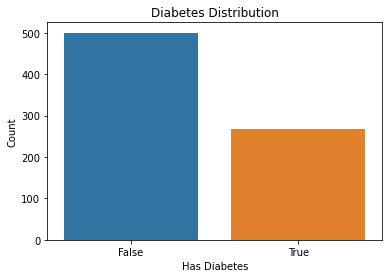

HasDiabetes
False          500
True           268

In [11]:
# Create HasDiabetes count plot
ax = sns.countplot(x = "HasDiabetes", data = df)
ax.set_xlabel("Has Diabetes")
ax.set_ylabel("Count")
ax.set_title("Diabetes Distribution")
plt.show()

# Create HasDiabetes frequency table
pd.DataFrame(df["HasDiabetes"].value_counts())

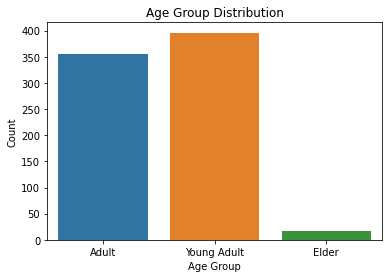

AgeGroup
Young Adult       396
Adult             356
Elder              16

In [12]:
# Create AgeGroup count plot
ax = sns.countplot(x = "AgeGroup", data = df)
ax.set_xlabel("Age Group")
ax.set_ylabel("Count")
ax.set_title("Age Group Distribution")
plt.show()

# Create AgeGroup frequency table
pd.DataFrame(df["AgeGroup"].value_counts())

We have very few Elders in our dataset. Most of the individuals in our dataset are either Adults or Young Adults.

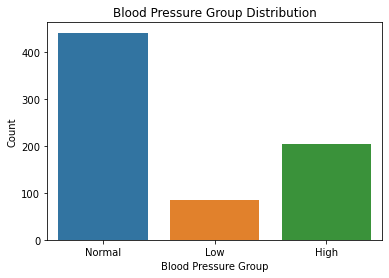

BloodPressureGroup
Normal                 442
High                   205
Low                     86

In [13]:
# Create BloodPressureGroup count plot
ax = sns.countplot(x = "BloodPressureGroup", data = df)
ax.set_xlabel("Blood Pressure Group")
ax.set_ylabel("Count")
ax.set_title("Blood Pressure Group Distribution")
plt.show()

# Create BloodPressureGroup frequency table
pd.DataFrame(df["BloodPressureGroup"].value_counts())

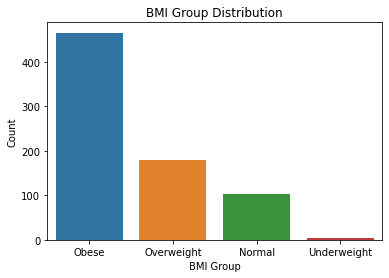

BMIGroup
Obese             465
Overweight        179
Normal            102
Underweight         4

In [14]:
# Create BMIGroup count plot
ax = sns.countplot(x = "BMIGroup", data = df)
ax.set_xlabel("BMI Group")
ax.set_ylabel("Count")
ax.set_title("BMI Group Distribution")
plt.show()

# Create BMIGroup frequency table
pd.DataFrame(df["BMIGroup"].value_counts())

Surprisingly, majority of our dataset is obese with very few indivduals who are underweight.

#### Scatterplots

In [15]:
# Scatterplots for all pairs of numerical variables
# With hue on AgeGroup
sns.pairplot(df[np.append(numerical_columns, "AgeGroup")], hue="AgeGroup")

It seems like there could be a positive correlation between BMI and SkinThickness.

In [16]:
# Scatterplots for all pairs of numerical variables
# With hue on BloodPressureGroup
sns.pairplot(df[np.append(numerical_columns, "BloodPressureGroup")], hue="BloodPressureGroup")

If we look at the relationship of BMI and SkinThickness, it looks like there are two clusters on Low blood pressure and High blood pressure.

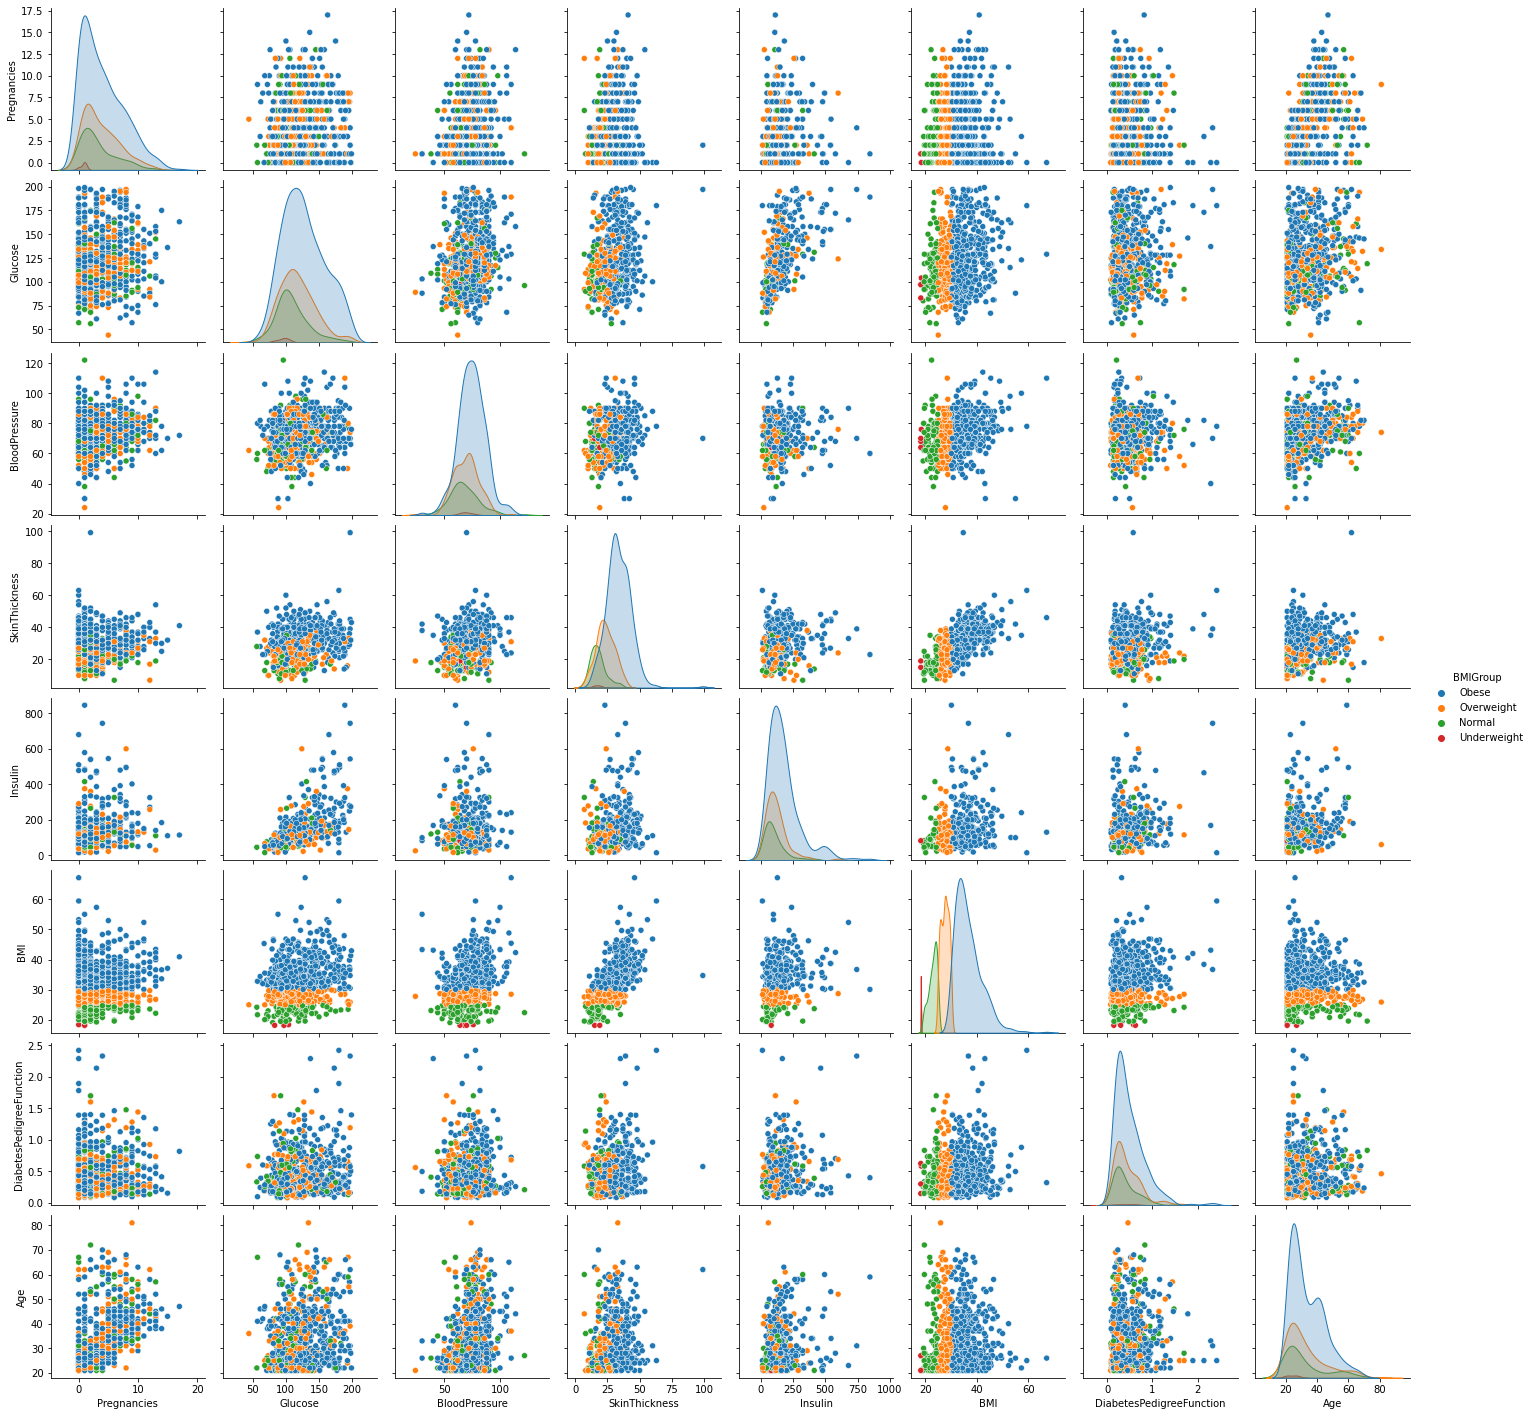

In [17]:
# Scatterplots for all pairs of numerical variables
# With hue on BMIGroup
sns.pairplot(df[np.append(numerical_columns, "BMIGroup")], hue="BMIGroup")

#### Correlation plot

Text(0.5, 1.0, 'Correlation Heatmap')

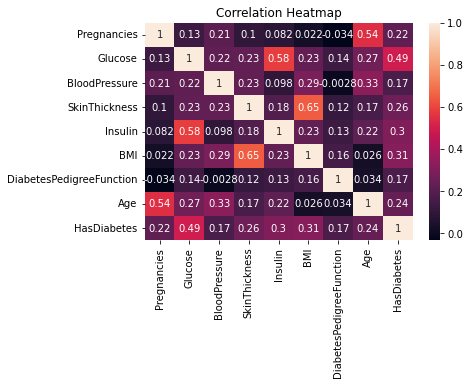

In [18]:
# Create correlation plot 
ax = sns.heatmap(df.corr(), annot=True);
ax.set_title("Correlation Heatmap")

There is a correlation of 0.65 between BMI and SkinThickness. Let's explore the effect of our predictors on SkinThickness. We will use BMI, BMIGroup and other predictors.

#### Boxplots

[(0.0, 70.0)]

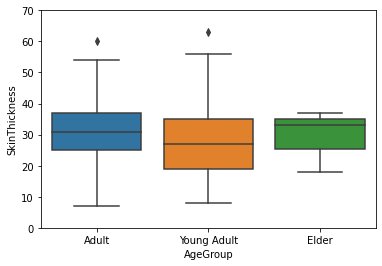

In [19]:
# Boxplot of AgeGroup vs SkinThickness
ax = sns.boxplot(x="AgeGroup", y="SkinThickness", data=df)

# Limit y-axis
ax.set(ylim=(0, 70))

Comparing the means between age group on SkinThickness, it doesen't look like there is a huge difference between groups.

In [20]:
# Boxplot of BloodPressureGroup vs SkinThickness
ax = sns.boxplot(x="BloodPressureGroup", y="SkinThickness", data=df)

# Limit y-axis
ax.set(ylim=(0, 70))

[(0.0, 70.0)]

The means of SkinThickness are more noticeably different between blood pressure groups. We see that high blood pressure have a larger skin thickness, followed by normal blood pressure and finally low blood pressure.

In [21]:
# Boxplot of BMIGroup vs SkinThickness
ax = sns.boxplot(x="BMIGroup", y="SkinThickness", data=df)

# Limit y-axis
ax.set(ylim=(0, 70))

[(0.0, 70.0)]

Looks like we have the largest difference between skin thickness means across BMI groups. Let's explore this further.

## Power Analysis

#### Determine sample size

In [22]:
# Parameters for our power analysis
effect_size = 0.8
alpha = 0.05
power = 0.8

# Run power analysis for sample t-test
analysis = TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample Size:', result)

Sample Size: 25.52457250047935


Above we run a power analysis to determine the sample size that is required to achieve a power of 80% (20% of type II error).

We use the following parameters for our power analysis:

A power of 0.8. Which means that there is a 20% probability of type II error.

An alpha level of 0.05 or 5%.

We assume that we have an effect size of 0.8. The effect size quantifies the difference between the means two groups, this can be measured using the Cohen’s d measure. A rule of thumb for Cohen’s d is that a large effect is roughly above a effect size of 0.8 [3].

Running the power analysis we receive a sample size of 25. This is a good sign because our sample size in our dataset is quite larger than 25.

#### Varying effect sizes on sample size

In this section we are going to explore the relatioship of effect size on sample size in our power analysis.

In [23]:
# Parameters for our power analysis
effect_size = np.arange(0.2, 1, 0.2)
alpha = 0.05
power = 0.8

def power_analysis_func(row):
    analysis = TTestIndPower()
    return analysis.solve_power(effect_size=row["Effect Size"], power=power, nobs1=None, ratio=1.0, alpha=alpha)

power_analysis_df = pd.DataFrame({"Effect Size": effect_size, "Alpha": alpha, "Power": power})
power_analysis_df["Sample Size"] = power_analysis_df.apply(power_analysis_func, axis=1)
power_analysis_df

Effect Size  Alpha  Power  Sample Size
0          0.2   0.05    0.8   393.405699
1          0.4   0.05    0.8    99.080327
2          0.6   0.05    0.8    44.585790
3          0.8   0.05    0.8    25.524573

As we can see from the table above as effect size increases, the sample size required decreases. This is assuming we have an alpha significance level of 0.05 and we want to achieve a power of 0.8 (20% probability of achieving type II error).

In [24]:
ax = sns.lineplot(data=power_analysis_df, x="Effect Size", y="Sample Size")
ax.set_title("Effect size v.s. Sample Size (alpha = 0.05, power = 0.8)")
plt.show()

We can see again in this plot, if we hold alpha and power constant, that as effect size increases the sample size decreases to achieve the same amount of power.

#### Varying effect sizes on power

In this section we will explore the relationship of effect size on power.

In [25]:
# Parameters for our power analysis
effect_size = np.arange(0.1, 1, 0.1)
alpha = 0.05
sample_size = 100

def power_analysis_func(row):
    analysis = TTestIndPower()
    return analysis.solve_power(effect_size=row["Effect Size"], power=None, nobs1=sample_size, ratio=1.0, alpha=alpha)

power_analysis_df = pd.DataFrame({"Effect Size": effect_size, "Alpha": alpha, "Sample Size": sample_size})
power_analysis_df["Power"] = power_analysis_df.apply(power_analysis_func, axis=1)
power_analysis_df

Effect Size  Alpha  Sample Size     Power
0          0.1   0.05          100  0.108372
1          0.2   0.05          100  0.290646
2          0.3   0.05          100  0.560059
3          0.4   0.05          100  0.803647
4          0.5   0.05          100  0.940427
5          0.6   0.05          100  0.988152
6          0.7   0.05          100  0.998490
7          0.8   0.05          100  0.999878
8          0.9   0.05          100  1.000000

We can see in our table above that as effect size increases so does the power of our experiment. This assumes a that we have an alpha significance level of 0.05 and we hold sample size constant at 100 observations.

In [26]:
ax = sns.lineplot(data=power_analysis_df, x="Effect Size", y="Power")
ax.set_title("Effect size v.s. Power (alpha = 0.05, Sample_Size = 100)")
plt.show()

In the plot above we can see this behaviour again. If we hold the alpha significance level and sample size constant, as effect size increases we have an increase of power.

#### Varying sample sizes on power

In this section we are going to look at the relationship of sample size on power. 

In [27]:
# Parameters for our power analysis
sample_size = np.arange(10, 120, 25)
alpha = 0.05
effect_size = 0.8

def power_analysis_func(row):
    analysis = TTestIndPower()
    return analysis.solve_power(effect_size=effect_size, power=None, nobs1=row["Sample Size"], ratio=1.0, alpha=alpha)

power_analysis_df = pd.DataFrame({"Sample Size": sample_size, "alpha": alpha, "Effect size": effect_size})
power_analysis_df["Power"] = power_analysis_df.apply(power_analysis_func, axis=1)
power_analysis_df

Sample Size  alpha  Effect size     Power
0           10   0.05          0.8  0.395069
1           35   0.05          0.8  0.909723
2           60   0.05          0.8  0.991481
3           85   0.05          0.8  0.999371
4          110   0.05          0.8  1.000000

The table shows that as we increase our sample size, our power likewise increases, assuming we hold our alpha level and effect size constant.

In [28]:
# Parameters for power analysis
effect_sizes = np.arange(0.2, 1, 0.2)
sample_sizes = np.arange(5, 100)
# calculate power curves from multiple power analyses
analysis = TTestIndPower()
analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

In the above plot we can see the relationship between the number of observations (sample size) and the power of an experiment. We can see this relationshop for varying effect sizes. We see that as the number of observations increases, in general our power increases. Likewise as our effect size increases, the rate at which the number of observations attains higher power is much quicker. An increase in both number of observations and effect size will increase the power of our experiment.

#### Calculating power for Blood Pressure Groups

In this we are going to calculate power for all combinations of blood pressure groups from our dataset.

In [29]:
# Create a table with all combinations of blood pressure group with the sample size
bp_value_count = pd.DataFrame(df["BloodPressureGroup"].value_counts()).reset_index()
bp_combinations1 = pd.DataFrame(list(combinations(list(bp_value_count["index"]), 2)), columns=["bpg1", "bpg2"])
bp_combinations2 = pd.merge(bp_combinations1, bp_value_count, left_on="bpg1", right_on="index")
bp_combinations = pd.merge(bp_combinations2, bp_value_count, left_on="bpg2", right_on="index")
bp_combinations.drop(["index_x", "index_y"], axis=1, inplace=True)
bp_combinations.rename(columns={"BloodPressureGroup_x": "samplesize1", "BloodPressureGroup_y": "samplesize2"}, inplace=True)
bp_combinations

bpg1  bpg2  samplesize1  samplesize2
0  Normal  High          442          205
1  Normal   Low          442           86
2    High   Low          205           86

In [30]:
# Parameters for our power analysis
effect_size = 0.8
alpha = 0.05

# Function to calculate power for one row
def power_analysis_func(row):
    ratio = (row["samplesize2"] / row["samplesize1"])
    analysis = TTestIndPower()
    return analysis.solve_power(effect_size=effect_size, power=None, nobs1=row["samplesize1"], ratio=1.0, alpha=alpha)

bp_combinations["power"] = bp_combinations.apply(power_analysis_func, axis=1)
bp_combinations

bpg1  bpg2  samplesize1  samplesize2  power
0  Normal  High          442          205    1.0
1  Normal   Low          442           86    1.0
2    High   Low          205           86    1.0

We see that for all combinations of blood presssure groups, we achieve a power of close to 1. This is assuming that we have an alpha significance level at 0.05 and that our effect size is 0.8. 

#### Calculating power for Age Groups

In this we are going to calculate power for all combinations of age group in our dataset.

In [31]:
# Create a table with all combinations of age group with the sample size
age_value_count = pd.DataFrame(df["AgeGroup"].value_counts()).reset_index()
age_combinations1 = pd.DataFrame(list(combinations(list(age_value_count["index"]), 2)), columns=["age1", "age2"])
age_combinations2 = pd.merge(age_combinations1, age_value_count, left_on="age1", right_on="index")
age_combinations = pd.merge(age_combinations2, age_value_count, left_on="age2", right_on="index")
age_combinations.drop(["index_x", "index_y"], axis=1, inplace=True)
age_combinations.rename(columns={"AgeGroup_x": "samplesize1", "AgeGroup_y": "samplesize2"}, inplace=True)
age_combinations

age1   age2  samplesize1  samplesize2
0  Young Adult  Adult          396          356
1  Young Adult  Elder          396           16
2        Adult  Elder          356           16

In [32]:
# Parameters for our power analysis
effect_size = 0.8
alpha = 0.05

# Function to calculate power for one row
def power_analysis_func(row):
    ratio = (row["samplesize2"] / row["samplesize1"])
    analysis = TTestIndPower()
    return analysis.solve_power(effect_size=effect_size, power=None, nobs1=row["samplesize1"], ratio=1.0, alpha=alpha)

age_combinations["power"] = age_combinations.apply(power_analysis_func, axis=1)
age_combinations

age1   age2  samplesize1  samplesize2  power
0  Young Adult  Adult          396          356    1.0
1  Young Adult  Elder          396           16    1.0
2        Adult  Elder          356           16    1.0

We see again that for all combinations of age groups, we achieve a power of close to 1. This is assuming that we have an alpha significance level at 0.05 and that our effect size is 0.8. 

#### Calculating power for BMI groups

In this we are going to calculate power for all combinations of BMI groups in our dataset.

In [33]:
# Create a table with all combinations of BMI group with the sample size
bmi_value_count = pd.DataFrame(df["BMIGroup"].value_counts()).reset_index()
bmi_combinations1 = pd.DataFrame(list(combinations(list(bmi_value_count["index"]), 2)), columns=["age1", "age2"])
bmi_combinations2 = pd.merge(bmi_combinations1, bmi_value_count, left_on="age1", right_on="index")
bmi_combinations = pd.merge(bmi_combinations2, bmi_value_count, left_on="age2", right_on="index")
bmi_combinations.drop(["index_x", "index_y"], axis=1, inplace=True)
bmi_combinations.rename(columns={"BMIGroup_x": "samplesize1", "BMIGroup_y": "samplesize2"}, inplace=True)
bmi_combinations

age1         age2  samplesize1  samplesize2
0       Obese   Overweight          465          179
1       Obese       Normal          465          102
2  Overweight       Normal          179          102
3       Obese  Underweight          465            4
4  Overweight  Underweight          179            4
5      Normal  Underweight          102            4

In [34]:
# Parameters for our power analysis
effect_size = 0.8
alpha = 0.05

# Function to calculate power for one row
def power_analysis_func(row):
    ratio = (row["samplesize2"] / row["samplesize1"])
    analysis = TTestIndPower()
    return analysis.solve_power(effect_size=effect_size, power=None, nobs1=row["samplesize1"], ratio=1.0, alpha=alpha)

bmi_combinations["power"] = bmi_combinations.apply(power_analysis_func, axis=1)
bmi_combinations

age1         age2  samplesize1  samplesize2     power
0       Obese   Overweight          465          179  1.000000
1       Obese       Normal          465          102  1.000000
2  Overweight       Normal          179          102  1.000000
3       Obese  Underweight          465            4  1.000000
4  Overweight  Underweight          179            4  1.000000
5      Normal  Underweight          102            4  0.999903

We see that for all BMI group combinations we achive a power close to 1. Other than the combinations of Normal BMI to Underweight BMI we achive a power slightly lower of 0.99. This is probably because we have a low number of sample in this experiment of comparing these two groups. This is assuming that we have an alpha significance level at 0.05 and that our effect size is 0.8. 

## ANOVA

Let's dive into this relationship further by conducting an ANOVA test. If our ANOVA is significant, we will conduct a post-hoc tukey test and post-hoc bonferroni to see exactly which groups have a significant difference in their skin thickness means.

#### SkinThickness ~ AgeGroup

In [35]:
# Do ANOVA on SkinThickness ~ AgeGroup
aov = pg.anova(data=df, dv='SkinThickness',between='AgeGroup',detailed=True)
aov

Source            SS   DF          MS         F   p-unc       np2
0  AgeGroup   1430.446252    2  715.223126  6.652224  0.0014  0.024133
1    Within  57843.819922  538  107.516394       NaN     NaN       NaN

Our ANOVA between age group and skin thickness gives us a p-value of 0.0014. Therefore we reject the null hypothesis that all age group means are equal and we will conduct post-hoc tukey test.

In [36]:
# Do post-hoc tukey test SkinThickness ~ AgeGroup
pt = pg.pairwise_tukey(dv='SkinThickness',between='AgeGroup', effsize='cohen', data=df)
pt

A            B    mean(A)    mean(B)      diff        se         T  \
0  Adult        Elder  31.075556  29.333333  1.742222  6.026330  0.289102   
1  Adult  Young Adult  31.075556  27.769968  3.305588  0.906286  3.647402   
2  Elder  Young Adult  29.333333  27.769968  1.563365  6.015173  0.259904   

    p-tukey     cohen  
0  0.954977  0.168022  
1  0.000848  0.318795  
2  0.963450  0.150773

Our post-hoc tukey test of age group and skin thickness shows that the significant difference in means is between the groups "Adult" and "Young Adult". We received a p-adjusted of 0.0008, below the 0.01 significance level.

In [37]:
# Do post-hoc bonferroni SkinThickness ~ AgeGroup
mod = ols('SkinThickness ~ AgeGroup', data=df).fit()
pair_t = mod.t_test_pairwise('AgeGroup')
pair_t.result_frame

coef   std err         t     P>|t|  Conf. Int. Low  \
Elder-Adult       -1.742222  6.026330 -0.289102  0.772615      -13.580243   
Young Adult-Adult -3.305588  0.906286 -3.647402  0.000291       -5.085880   
Young Adult-Elder -1.563365  6.015173 -0.259904  0.795038      -13.379469   

                   Conf. Int. Upp.  pvalue-hs  reject-hs  
Elder-Adult              10.095798   0.948296      False  
Young Adult-Adult        -1.525295   0.000872       True  
Young Adult-Elder        10.252738   0.948296      False

From our bonferroni post-hoc test we can see that our only significant difference is between the means of the groups "Young Adult" and "Adult". We can also see our corresponding confidence intervals.

#### SkinThickness ~ BloodPressureGroup

In [38]:
# Do ANOVA on SkinThickness ~ BloodPressureGroup
aov = pg.anova(data=df, dv='SkinThickness',between='BloodPressureGroup',detailed=True)
aov

Source            SS   DF           MS          F     p-unc  \
0  BloodPressureGroup   2265.656317    2  1132.828158  10.658174  0.000029   
1              Within  56969.976336  536   106.287269        NaN       NaN   

        np2  
0  0.038248  
1       NaN

Our ANOVA between blood pressure group and skin thickness gives us a p-value of 0.000002. This is significant under the 0.01 significance level. Therefore we reject the null hypothesis that all age group means are equal and we will conduct post-hoc tukey test.

In [39]:
# Do post-hoc tukey test SkinThickness ~ BloodPressureGroup
pt = pg.pairwise_tukey(dv='SkinThickness',between='BloodPressureGroup', effsize='cohen', data=df)
pt

A       B    mean(A)    mean(B)      diff        se         T   p-tukey  \
0  High     Low  31.928571  25.138889  6.789683  1.495128  4.541206  0.000021   
1  High  Normal  31.928571  28.865443  3.063128  1.041265  2.941738  0.009524   
2   Low  Normal  25.138889  28.865443 -3.726555  1.342106 -2.776646  0.015662   

      cohen  
0  0.658580  
1  0.297115  
2 -0.361466

From our post-hoc tukey test we see that we have a significant difference between all blood pressure group's skin thickness means. The most significance is the difference between the groups "High" blood pressure and "Low" blood pressure at a p-value of 0.00002.

In [40]:
# Do post-hoc bonferroni SkinThickness ~ BloodPressureGroup
mod = ols('SkinThickness ~ BloodPressureGroup', data=df).fit()
pair_t = mod.t_test_pairwise('BloodPressureGroup')
pair_t.result_frame

coef   std err         t     P>|t|  Conf. Int. Low  \
Low-High    -6.789683  1.495128 -4.541206  0.000007       -9.726711   
Normal-High -3.063128  1.041265 -2.941738  0.003405       -5.108588   
Normal-Low   3.726555  1.342106  2.776646  0.005684        1.090121   

             Conf. Int. Upp.  pvalue-hs  reject-hs  
Low-High           -3.852654   0.000021       True  
Normal-High        -1.017668   0.006798       True  
Normal-Low          6.362988   0.006798       True

From our Bonferroni post-hoc we see that all groups have a significant difference from one another. We can also see our corresponding confidence intervals.

#### SkinThickness ~ BMIGroup

In [41]:
# Do ANOVA on SkinThickness ~ BMIGroup
aov = pg.anova(data=df, dv='SkinThickness',between='BMIGroup',detailed=True)
aov

Source            SS   DF           MS          F         p-unc       np2
0  BMIGroup  19369.594286    3  6456.531429  87.280222  6.381208e-46  0.330256
1    Within  39280.585153  531    73.974737        NaN           NaN       NaN

Our ANOVA between BMI group and skin thickness gives us a p-value of 6.3e-46. This is significant under the 0.01 significance level. Therefore we reject the null hypothesis that all age group means are equal and we will conduct post-hoc tukey test.

In [42]:
# Do post-hoc tukey test SkinThickness ~ BMIGroup
pt = pg.pairwise_tukey(dv='SkinThickness',between='BMIGroup', effsize='cohen', data=df)
pt

A            B    mean(A)    mean(B)       diff        se  \
0      Normal        Obese  17.600000  33.520231 -15.920231  1.202793   
1      Normal   Overweight  17.600000  23.220472  -5.620472  1.347364   
2      Normal  Underweight  17.600000  17.000000   0.600000  6.182255   
3       Obese   Overweight  33.520231  23.220472  10.299759  0.892344   
4       Obese  Underweight  33.520231  17.000000  16.520231  6.099276   
5  Overweight  Underweight  23.220472  17.000000   6.220472  6.129425   

           T       p-tukey     cohen  
0 -13.236047  6.805667e-14 -1.851005  
1  -4.171457  2.065721e-04 -0.653478  
2   0.097052  9.996724e-01  0.069760  
3  11.542362  6.805667e-14  1.197527  
4   2.708556  3.507265e-02  1.920766  
5   1.014854  7.408157e-01  0.723239

From our post-hoc tukey test, we see that we have strong differences between the means of "Normal" to "Obese" and "Obese" to "Overweight" with p-values of 6.8e-14 and 6.8e-14 respectively. We also have a significant p-values from the pairs of groups: "Normal"-"Overweight" (p-value: 0.0002), "Obese"-"Underweight" (p-value: 0.02), under the 0.05 significance level.

In [43]:
# Do post-hoc bonferroni SkinThickness ~ BMIGroup
mod = ols('SkinThickness ~ BMIGroup', data=df).fit()
pair_t = mod.t_test_pairwise('BMIGroup')
pair_t.result_frame

coef   std err          t         P>|t|  \
Obese-Normal            15.920231  1.202793  13.236047  9.181093e-35   
Overweight-Normal        5.620472  1.347364   4.171457  3.535149e-05   
Underweight-Normal      -0.600000  6.182255  -0.097052  9.227217e-01   
Overweight-Obese       -10.299759  0.892344 -11.542362  1.181882e-27   
Underweight-Obese      -16.520231  6.099276  -2.708556  6.975722e-03   
Underweight-Overweight  -6.220472  6.129425  -1.014854  3.106375e-01   

                        Conf. Int. Low  Conf. Int. Upp.     pvalue-hs  \
Obese-Normal                 13.557414        18.283049  5.508656e-34   
Overweight-Normal             2.973654         8.267291  1.413985e-04   
Underweight-Normal          -12.744679        11.544679  9.227217e-01   
Overweight-Obese            -12.052717        -8.546801  5.909411e-27   
Underweight-Obese           -28.501903        -4.538560  2.078152e-02   
Underweight-Overweight      -18.261369         5.820424  5.247794e-01   

                        reject-hs  
Obese-Normal                 True  
Overweight-Normal            True  
Underweight-Normal          False  
Overweight-Obese             True  
Underweight-Obese            True  
Underweight-Overweight      False

From our bonferroni post-hoc test we can see that we have significant difference between four of the groups that are shown above. We can also see our corresponding confidence intervals.

## T-Tests

Lets explore the relationship of our 3 categorical variables: age group, blood pressure group, and BMI group on skin thickness. We will use t-test on every possible combination of values in our categorical variable.

In [44]:
# Function to do ttest on all combinations of values in the categorical_var
# using numerical_var as the dependent variable
# Returns a dataframe of all the results
def do_ttest_for_all_categorical_pairs(categorical_var, numerical_var, data):
    group_names = []
    t_statistics = []
    p_values = []
    for groups in combinations(data[categorical_var].unique(), 2):
        if groups[0] == None or groups[1] == None: continue
        group1 = normal = data[numerical_var][data[numerical_var].notnull()][data[categorical_var] == groups[0]]
        group2 = data[numerical_var][data[numerical_var].notnull()][data[categorical_var] == groups[1]]
        t_stat, p_value = stats.ttest_ind(group1, group2)
        group_names.append(f"{groups[0]}-{groups[1]}")
        t_statistics.append(t_stat)
        p_values.append(p_value)

    ttest_result_df = pd.DataFrame({"groups": group_names, "t-statistic": t_statistics, "p-value": p_values})
    return ttest_result_df

In [45]:
# Do ttest between AgeGroup's on SkinThickness
do_ttest_for_all_categorical_pairs(categorical_var="AgeGroup", numerical_var="SkinThickness", data=df)

groups  t-statistic   p-value
0  Adult-Young Adult     3.646947  0.000291
1        Adult-Elder     0.290990  0.771326
2  Young Adult-Elder    -0.258757  0.795993

From our t-test comparing skin thickness means between age groups, we can see that the only significant difference is between the "Adult" and "Young Adult" groups with a p-value = 0.0002 and a t-statistic of 0.29. A significance less than alpha of 0.01. "Adult" to "Elder", and "Young Adult" to "Elder" are not significant, p > 0.05. This may be because we have a low number of samples for the group "Elder".

In [46]:
# Do ttest between BloodPressureGroup's on SkinThickness
do_ttest_for_all_categorical_pairs(categorical_var="BloodPressureGroup", numerical_var="SkinThickness", data=df)

groups  t-statistic   p-value
0   Normal-Low     2.799879  0.005362
1  Normal-High    -2.909544  0.003793
2     Low-High    -4.582706  0.000008

Our t-test between blood pressure groups on skin thickness show that we have significant relationships between all blood pressure groups. All the p-values are less than 0.01 significance level.

In [47]:
# Do ttest between BMIGroup's on SkinThickness
do_ttest_for_all_categorical_pairs(categorical_var="BMIGroup", numerical_var="SkinThickness", data=df)

groups  t-statistic       p-value
0        Obese-Overweight    11.184683  6.458085e-26
1            Obese-Normal    12.598560  6.310004e-31
2       Obese-Underweight     2.467984  1.407072e-02
3       Overweight-Normal     5.307986  3.150855e-07
4  Overweight-Underweight     1.239909  2.172951e-01
5      Normal-Underweight     0.138660  8.901830e-01

Our t-test between BMI groups skin thickness show multiple significant results. Groups "Obese" to "Overweight", "Obese" to "Normal", and "Overweight" to "Normal" have a p-value of significance less than the 0.01 level. The groups of "Obese" to "Underweight" have a p-value of 0.02 which is significant under the 0.05 level.

## Multiple Linear Regression

Let's use Multiple Linear Regression to build a model to predict skin thickness using numerical predictors.

In [48]:
# Lets have a look at the non-null count
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   HasDiabetes               768 non-null    bool   
 9   AgeGroup                  768 non-null    object 
 10  BloodPressureGroup        733 non-null    object 
 11  BMIGroup                  750 non-null    object 
dtypes: bool(1), float64(6), int64(2), object(3)
memory usage: 66.9+ KB


We see that for some of the columns we have many null values, lets choose numerical predictors that have majority non-null values. We are going to use the following columns for our predictors:

- number of pregnancies
- glucose
- BMI
- diabetes pedigree function
- age
- blood pressure

In [49]:
# Lets keep the columns that are mostly non-null and create a new dataframe with filtered null rows
df_nan_removed = df[["Pregnancies", "Glucose", "BMI", "DiabetesPedigreeFunction", "Age", "BloodPressure", "SkinThickness"]].dropna()
df_nan_removed.shape

(532, 7)

After removing our null values we have remaining 532 observations.

In [50]:
# Split our features variables from our target variable
X = df_nan_removed.iloc[:,:-1]
y = df_nan_removed.iloc[:,-1]

# Split our dataset to training set (80%) and testing set (20%) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [51]:
# Train Multiple Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [52]:
# Display our coefficients
coeff_df = pd.DataFrame(lr.coef_,X.columns, columns=['Coefficient'])
coeff_df

Coefficient
Pregnancies                  0.096101
Glucose                      0.014363
BMI                          0.938088
DiabetesPedigreeFunction     1.716663
Age                          0.090561
BloodPressure               -0.037913

We can see from our coefficients that diabetes pedigree function has the largest effect on our dependent variable - skin thickness, with a coefficient of 1.71. Also, BMI seems have a considereable impact on our dependent variable with a coefficient of 0.93.

In [53]:
# Print our y-intercept
print("Our Multiple Linear Regression intercept is: ", lr.intercept_)

Our Multiple Linear Regression intercept is:  -4.671624619320326


In [54]:
# Display some predictions with their corresponding actual values
pd.DataFrame({"actual": y_test, "predicted": y_pred}).head()

actual  predicted
580    46.0  36.117109
421    18.0  21.547683
692    32.0  34.887643
120    56.0  48.246980
550    28.0  22.392206

In [55]:
# Evaluate our model using: mean absolute error, mean squared error, root mean squared error and R-squared
print('MAE:',metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
print('R-squared', metrics.r2_score(y_test, y_pred))

MAE: 6.574800902973146
MSE: 64.5567177776264
RMSE: 8.034719520781444
R-squared 0.4537195049793239


We have a mean absolute error of 6.5, a mean squared error of 64.5, a root mean squared error of 8.3 and an r-squared 0.45. Considering that r-squared ranges from 0 to 1, we will conclude that our linear model is able to moderately determine skin thickness, our dependent variable.

## ANCOVA

In this section I will be running an ANCOVA test controlling for the covariate Age. I will be assessing the difference in means of SkinThickness. The reason we are doing this is to see that if we control for age, will there remain a significant difference between our group means. 

#### SkinThickness ~ BloodPressureGroup with covariate=Age

In [56]:
# Run ANCOVA
pg.ancova(data=df, dv='SkinThickness', between='BloodPressureGroup', covar='Age')

Source            SS   DF         F     p-unc       np2
0  BloodPressureGroup   1439.157255    2  6.855166  0.001149  0.024986
1                 Age    811.659986    1  7.732392  0.005615  0.014247
2            Residual  56158.316350  535       NaN       NaN       NaN

The first ANCOVA is comparing the group means of blood pressure groups controlling for age. The results show that there is a significant p-value of 0.001, which is significant under the 0.05 significance level.

#### SkinThickness ~ BMIGroup with covariate=Age

In [57]:
pg.ancova(data=df, dv='SkinThickness', between='BMIGroup', covar='Age')

Source            SS   DF          F         p-unc       np2
0  BMIGroup  18147.281672    3  82.484581  8.359625e-44  0.318287
1       Age    412.475368    1   5.624455  1.806794e-02  0.010501
2  Residual  38868.109785  530        NaN           NaN       NaN

Our second ANCOVA is comparing the group means of BMI groups controlling for age. The results show that there is a significant p-value of 8.35e-44, which is significant under the 0.05 significance level.

## Sources

[1] “High Blood Pressure and Older Adults.” National Institute on Aging, http://www.nia.nih.gov/health/high-blood-pressure-and-older-adults. Accessed 25 Mar. 2022.

[2] CDC. “Assessing Your Weight.” Centers for Disease Control and Prevention, 17 Sept. 2020, https://www.cdc.gov/healthyweight/assessing/index.html.

[3] Magnusson, Kristoffer. Interpreting Cohen’s d. Https://rpsychologist.com/cohend/. Accessed 6 Apr. 2022.